In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate

In [11]:
df_dengue = pd.read_csv('../Data/silver/dengue_no_split.csv')
df_zika = pd.read_csv('../Data/silver/zika.csv')
df_zika.drop(columns = ['Unnamed: 0'], inplace = True)
df_chic = pd.read_csv('../Data/silver/chicunguya.csv')
df_chic.drop(columns = ['Unnamed: 0'], inplace = True)

In [12]:
df_dengue.head()

,SEMANA,ANO,Casos,DATE
0,1,2007,315,2007-01-01
1,2,2007,236,2007-01-08
2,3,2007,252,2007-01-15
3,4,2007,305,2007-01-22
4,5,2007,360,2007-01-29


In [13]:
df_zika.head()

,SEMANA,ANO,Casos,DATE
0,32,2015,26,2015-08-03
1,33,2015,23,2015-08-10
2,34,2015,14,2015-08-17
3,35,2015,6,2015-08-24
4,36,2015,9,2015-08-31


In [14]:
df_chic.head()

,SEMANA,ANO,Casos,DATE
0,23,2014,13,2014-06-02
1,24,2014,10,2014-06-09
2,25,2014,8,2014-06-16
3,26,2014,6,2014-06-23
4,27,2014,8,2014-06-30


# SIR Model

Spread of disease in population fixed to **N** individuals over time *t*

* individuals *S* suceptible to be infected
* individuals *I* infected
* recovered from the disease individuals *R* (now are inmune)

where *S,I,R* are functions of *t*

Depends on parameters:
* $\beta >0$: rate of contraction
* $\gamma>0$: mean recovery rate

Individual *S* becomes infected after contact with *I*, then develops immunity: leaves *I* compartment at a $\gamma$ cure rate

**Model Functioning**

Assumptions:
* On average, individual *S* in the population encounters $\beta$ individuals per unit of time
* Rate of infected individuals leaving compartment *I* is $\gamma I$ per unit of time (once individual has been infected, he develops immunity)
* Populaton size $N = S+I+R$ is constant

System of equations:

$$
\frac{dS}{dt} = -\frac{\beta S}{N}I
$$
$$
\frac{dI}{dt} = \frac{\beta S}{N}I - \gamma I
$$
$$
\frac{dR}{dt} = \gamma I
$$
Suceptible -> ($\beta SI/N$) -> Infectious -> ($\gamma I$) -> Recovered


**Problem Formulation**



$$
X =
\begin{bmatrix}
S \\
I \\
R
\end{bmatrix}
$$

$$
\dot{X} =
\begin{pmatrix}
-\frac{\beta S}{N} I \\
\frac{\beta S}{N} I - \gamma I \\
\gamma I
\end{pmatrix}
= f(X)
$$

### R0
**R0** is average number of new infections due to sick individual, if"
* If **R0** >1 epidemic will persist
* Else: epidemic dies out
* If **R0** = 3, for example, a sick person passes it to three other people

# SIR proportions

**Time path**
Suceptible *S* -> Exposed *E* -> Infected *I* -> Removed *R*
All individuals are eveltually infected if transmision rate is positive
We want:
* Number of infections at given time (determine if healthcare is under preassure)
* how long caseload can be deferred (until vaccine is found)

Use lower case for fraction of population in each state, dynamics are:

$$
\begin{aligned}
\dot{s}(t) &= -\beta(t)s(t)i(t) \\
\dot{e}(t) &= \beta(t)s(t)i(t) - \sigma e(t) \\
\dot{i}(t) &= \sigma e(t)  - \gamma i(t)
\end{aligned}
$$


Here:
* $\beta(t)$ is transmission rate, rate of individuals bumping to others and expose them to virus
* $\sigma$ is infection rate (rate at which those exposed become infected)
* $\gamma$ is recovery rate (rate to recover or die)
* dot $\dot{y}$ is time derivative $dy/dt$
* Don model fraction of *R* of population because is sum of all fractions:

$$
r = 1-s-e-i
$$

We can also track $c = i+r$ which is cummulative caseload

System can be writen in vector as:

$$
\dot{x} = F(x,t),        x:= (s,e,i)
$$

**Parameters**
We get $\sigma$ and $\gamma$ fixed, biologically determined
According to Atkeson's notes:
* $\sigma = 1/5.2$, incubation of 5.2 days / COVID
* $\gamma = 1/18$, average duration of 18 days / COVID
* Transmission model is: $\beta(t) := R(t)\gamma$, where *R(t)* is effective reproduction number at time t

In [220]:


# Function F
def F(x,t, R0 =1.6, gamma = gamma_init, sigma = sigma_init):
    '''
    Time derivative of state vector
    * x is state vector (array)
    * t is time (scalar)
    * R0 is effective transmision rate, constant
    '''
    s,e,i = x
    # New exposure of suceptibles
    beta = R0(t) * gamma if callable(R0) else R0 * gamma
    ne = beta * s * i

    # time derivatives
    ds = -ne
    de = ne- sigma * e
    di = sigma * e - gamma * i
    
    return ds, de, di

In [221]:
# population size COL
pop_size = 50_000_000

# parameters gamma, sigma
gamma_init = 1/20 * 7
sigma_init = 1/5 * 7

# Set initial conditions of s, e, i
i_0 = 1e-7 
e_0 = 4 * i_0
s_0 = 1 - i_0 - e_0

# vector
x_0 = s_0, e_0, i_0


In [222]:
# Solve path numerically using odeint, for seq of dates t_vec
def solve_path(R0, t_vec, x_init = x_0, gamma = gamma_init, sigma = sigma_init):
    '''
    Solve for i(t) and c(t) via numerical integration,
    given time path for R0
    
    '''
    G = lambda x, t: F(x,t,R0, gamma, sigma)
    s_path, e_path, i_path =  integrate.odeint(G, x_init, t_vec).transpose()

    c_path = 1- s_path - e_path # cummulative cases
    
    return i_path, c_path

Experiments

In [223]:
# time 550 days (18 months)
t_length = 52*2
grid_size = 52*2
t_vec = np.linspace(0,t_length, grid_size)

In [224]:
# Constant R0
R0_vals = np.linspace (1.6,3.0,6)
labels = [f'$R0 = {r:.2f}$' for r in R0_vals]
i_paths, c_paths = [],[]

for r in R0_vals:
    i_path, c_path = solve_path(r, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)

In [225]:
# plot the paths
def plot_paths(paths, labels, times=t_vec):

    fig, ax = plt.subplots()

    for path, label in zip(paths, labels):
        ax.plot(times, path, label=label)

    ax.legend(loc='upper left')

    plt.show()

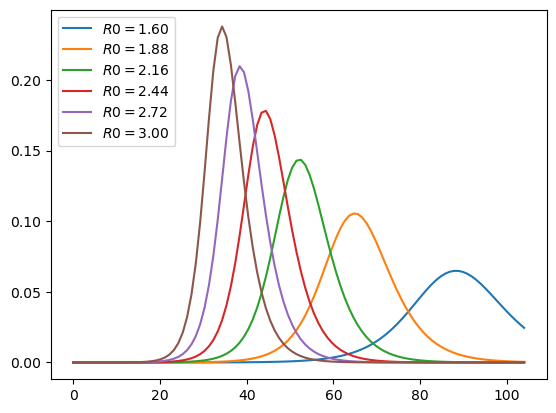

In [227]:
plot_paths(i_paths, labels)

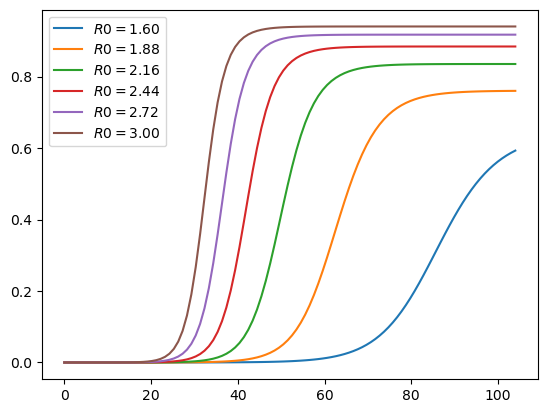

In [228]:
plot_paths(c_paths, labels)

# SIR with details

**Mitigation**
Social distance is imposed

In [172]:
# R0 as function of time
def R0_mitigating(t, r0=3, eta = 1, r_bar = 1.6):
    R0 = r0 * np.exp(-eta *t) + (1-np.exp(-eta *t)) * r_bar
    return R0

R0 starts at 3 and falls to 1.6 because of social distance
Parameter $\eta$ eta controls rate, speed of restrictions

In [173]:
# set different rates
eta_vals = 1/5, 1/10, 1/20, 1/50, 1/100
labels = [fr'$\eta = {eta:.2f}$'for eta in eta_vals]

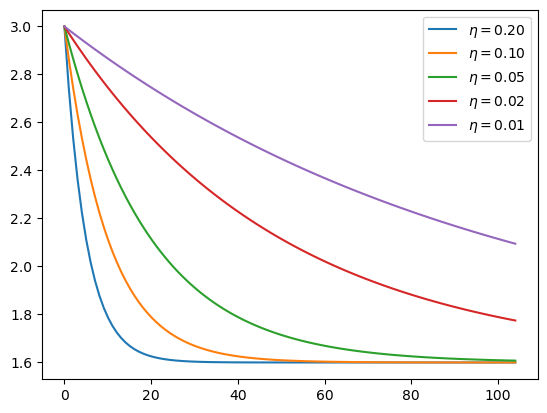

In [174]:
fig, ax = plt.subplots()

for eta, label in zip(eta_vals, labels):
    ax.plot(t_vec, R0_mitigating(t_vec, eta=eta), label=label)

ax.legend()
plt.show()

In [175]:
# Path for infected people
i_paths, c_paths = [], []

for eta in eta_vals:
    R0 = lambda t: R0_mitigating(t, eta = eta)
    i_path, c_path = solve_path(R0, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)

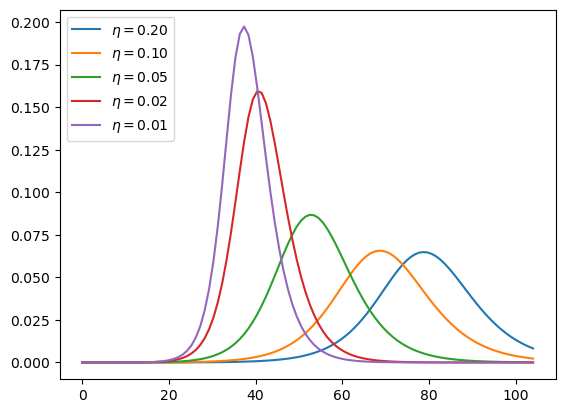

In [176]:
plot_paths(i_paths, labels)

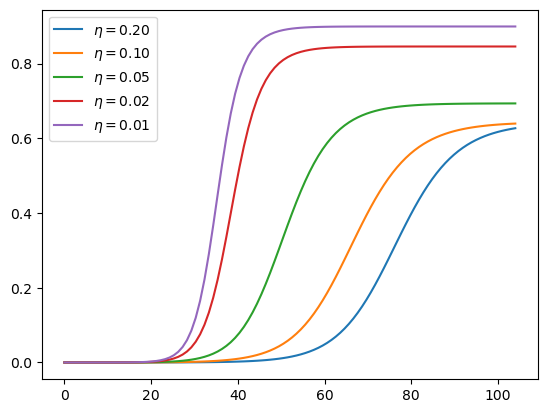

In [177]:
plot_paths(c_paths, labels)

**Ending Lockdown**
Results by Andrew Atkeson on timing lifting of lockdown with two scenarios:
* *Rt* = 0.5 for 30 days, then *Rt* =2 for rest of 17 months, is lifting lockdown in 30 days
* *Rt* = 0.5 for 120 days and *Rt* = 2 for 14 months, lift lockdown in 4 months

Consider initial 25k active and 75k agents exposed

In [178]:
# initial conditions
i_0 = 25_000 / pop_size
e_0 = 75_000 / pop_size
s_o = 1 - i_0 - e_0
x_0 = s_0, e_0, i_0

In [179]:
# get paths
R0_paths = (lambda t: 0.5 if t<1 else 2,
            lambda t: 0.5 if t<4 else 2)
labels = [f'scenario{i}' for i in (1,2)]

i_paths, c_paths = [],[]
for R0 in R0_paths:
    i_path, c_path = solve_path(R0, t_vec, x_init = x_0)
    i_paths.append(i_path)
    c_paths.append(c_path)

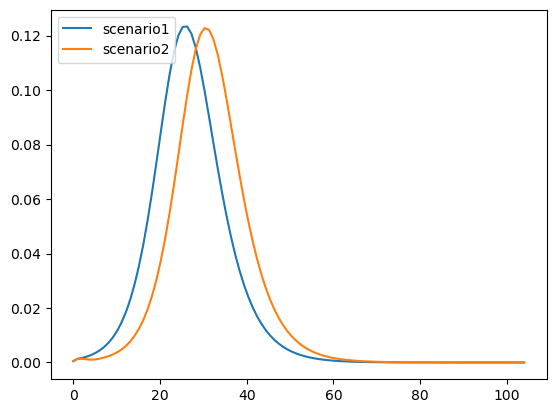

In [180]:
plot_paths(i_paths, labels)

What mortality to expect? say 1%

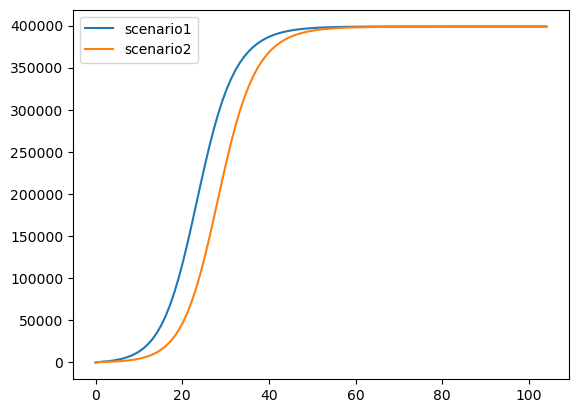

In [181]:
ni = 0.01
# cummulative deaths
paths = [path * ni * pop_size for path in c_paths]
plot_paths(paths, labels)

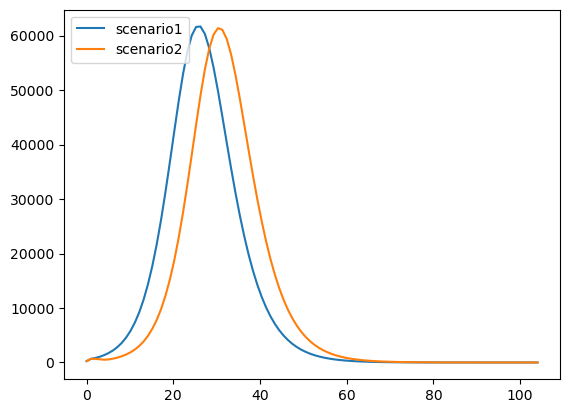

In [182]:
# daily death rate
paths = [path * ni * pop_size for path in i_paths]
plot_paths(paths, labels)

# Fit to real data

## Zika

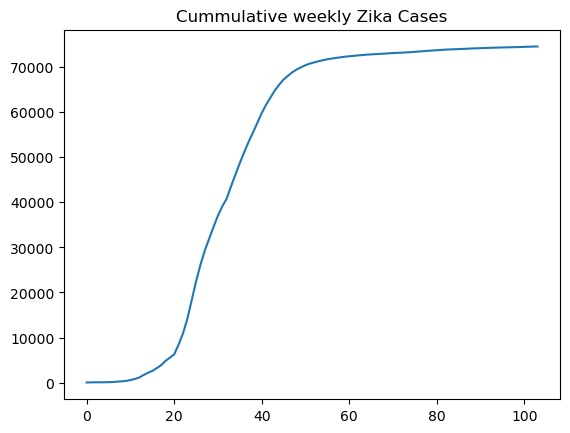

In [230]:
zika_new_cases = df_zika.Casos[0:104] # get only two years
zika_cases = np.cumsum(zika_new_cases)
plt.plot(zika_cases)
plt.title('Cummulative weekly Zika Cases')
plt.show()

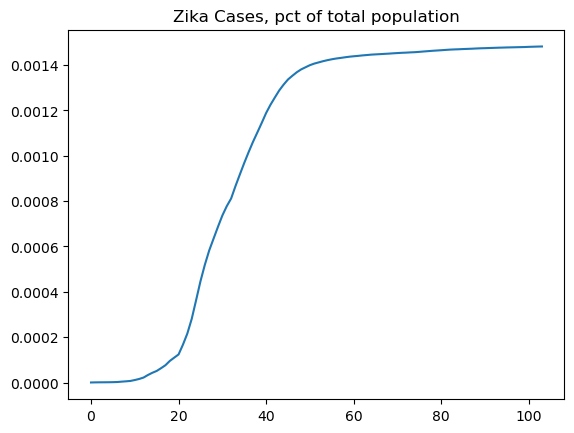

In [231]:
zika_new_cases_normal = zika_new_cases / pop_size_col
zika_cases_normal = zika_cases / pop_size_col
plt.plot(zika_cases_normal)
plt.title('Zika Cases, pct of total population')
plt.show()

In [236]:
zika_cases_normal[0]

np.float64(5.166212967194548e-07)

In [274]:
# parameters gamma, sigma
gamma_init = 1/10 * 7 # recovery rate
sigma_init = 1/100 * 7 # infection rate

# Set initial conditions of s, e, i
i_0 = 5e-7 
e_0 = 4 * i_0
s_0 = 1 - i_0 - e_0

# vector
x_0 = s_0, e_0, i_0

In [275]:
# time 550 days (18 months)
t_length = 104
grid_size = 104
t_vec = np.linspace(0,t_length, grid_size)

In [276]:
# Constant R0
R0_val_rand = 2.2 # arbitrary number
i_path, c_path = solve_path(R0_val_rand, t_vec, x_init=x_0, gamma=gamma_init, sigma=sigma_init)

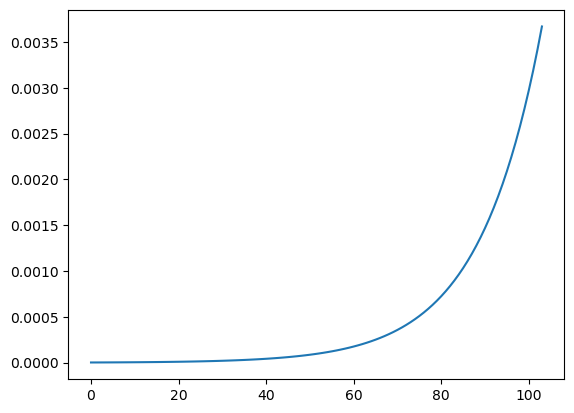

In [277]:
plt.plot(c_path)

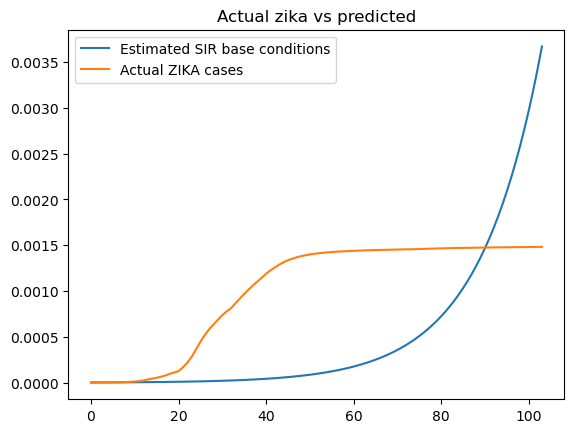

In [278]:
plt.plot(c_path, label = 'Estimated SIR base conditions')
plt.plot(zika_cases_normal, label = 'Actual ZIKA cases')
plt.legend()
plt.title('Actual zika vs predicted')
plt.show()

In [286]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize

# Example initial parameters (in weekly units, as per your scaling)
gamma_init = 1/3 * 7    # recovery rate (per week)
sigma_init = 1/100 * 7  # incubation rate (per week)

# Function defining the model's ODEs
def F(x, t, R0=1.6, gamma=gamma_init, sigma=sigma_init):
    s, e, i = x
    # If R0 is callable, then call it, else treat as constant
    beta = R0(t) * gamma if callable(R0) else R0 * gamma
    ne = beta * s * i
    ds = -ne
    de = ne - sigma * e
    di = sigma * e - gamma * i
    return [ds, de, di]

# Function to solve the ODE system given parameters
def solve_path(R0, t_vec, x_init=(0.99, 0.01, 0.0), gamma=gamma_init, sigma=sigma_init): #x_0 = s0, e0, i0
    G = lambda x, t: F(x, t, R0, gamma, sigma)
    s_path, e_path, i_path = odeint(G, x_init, t_vec).T
    c_path = 1 - s_path - e_path  # cumulative cases (assuming recovered is not tracked separately)
    return i_path, c_path

# Loss function: Mean Squared Error (MSE) between model cumulative cases and observed data
def loss_function(params, t_vec, actual_values, x_init=(0.99, 0.01, 0.0)): #x_0 = s0, e0, i0
    gamma, sigma, R0 = params
    # Solve the model using the current parameter guess
    _, c_path = solve_path(R0, t_vec, x_init, gamma, sigma)
    # Compute MSE between model cumulative cases and observed data
    mse = np.mean((c_path - actual_values) ** 2)
    return mse

# Time vector (assuming each step corresponds to one week)
t_vec = np.linspace(0, len(zika_cases_normal), len(zika_cases_normal))

# Initial guess for the parameters: gamma, sigma, and R0
initial_guess = [gamma_init, sigma_init, 1.6] # gamma, sigma, R0

# Optionally, set bounds for the parameters (e.g., gamma and sigma must be > 0, and R0 within a plausible range)
bounds = [(1e-4, None), (1e-4, None), (1.0, 10.0)]

# Run the optimization
result = minimize(loss_function, initial_guess, args=(t_vec, zika_cases_normal), bounds=bounds)

# Extract the best-fitting parameters
best_gamma, best_sigma, best_R0 = result.x
print(f"Optimal gamma: {best_gamma:.4f} per week")
print(f"Optimal sigma: {best_sigma:.4f} per week")
print(f"Optimal R0: {best_R0:.4f}")

Optimal gamma: 2.3315 per week
Optimal sigma: 0.0018 per week
Optimal R0: 1.4633


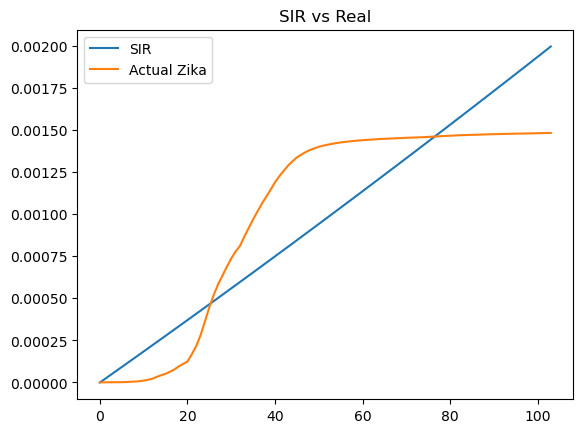

In [289]:
optimal_gamma = best_gamma
optimal_sigma = best_sigma

# Solve for i_path and c_path using the optimal parameters
i_path_optimal, c_path_optimal = solve_path(R0, t_vec, x_init, optimal_gamma, optimal_sigma)
plt.plot(c_path_optimal, label = 'SIR')
plt.plot(actual_values, label = 'Actual Zika')
plt.legend()
plt.title("SIR vs Real")
plt.show()

# SEIR

In [46]:
from scipy.integrate import solve_ivp

**Definition of SEIR**
Model has:
* *S* Suceptible individuals
* *E* exposed individuals (not yet infectious)
* *I* infectious* individuals
* *R* recovered individuals

Model is described by set of differential equations:

$$
\begin{aligned}
\dot{S} &= -\beta \frac{SI}{N} \\
\dot{E} &= \beta \frac{SI}{N} - \sigma E \\
\dot{I} &= \sigma E  - \gamma I \\
\dot{R} &=  \gamma I
\end{aligned}
$$

With:
* $\beta$ transmision rate
* $\sigma$ incubation rate (1/inucbation period)
* $\gamma$ recovery rate (1/infectious period )
* *N* total popualtion

In [47]:
#  Define Model
def seir_model(t, y, beta, sigma, gamma, N):
    S, E, I, R = y
    
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    
    return [dSdt, dEdt, dIdt, dRdt]

In [48]:
# Toy parameters
# Total population
N = 1000

# Initial conditions: S0, E0, I0, R0
S0 = 990
E0 = 5
I0 = 5
R0 = 0

# Parameters
beta = 0.3  # Transmission rate
sigma = 0.2  # Incubation rate (1/incubation period)
gamma = 0.1  # Recovery rate (1/infectious period)

# Time span (in days)
t_span = (0, 160)
t_eval = np.linspace(0, 160, 160)

In [49]:
# Solve toy problem
# Initial conditions vector
y0 = [S0, E0, I0, R0]

# Solve the SEIR model
sol = solve_ivp(seir_model, t_span, y0, args=(beta, sigma, gamma, N), t_eval=t_eval)

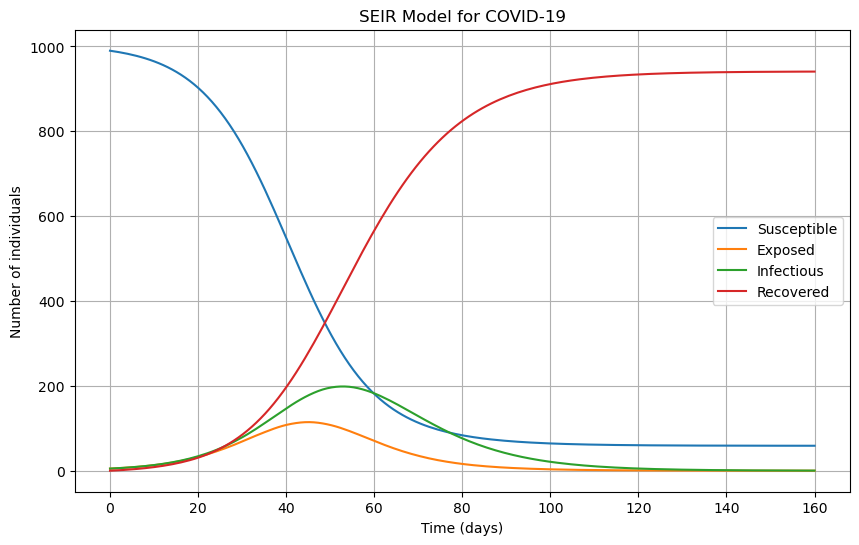

In [50]:
# Plot toy problem
# Extract the solution
S, E, I, R = sol.y

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, S, label='Susceptible')
plt.plot(sol.t, E, label='Exposed')
plt.plot(sol.t, I, label='Infectious')
plt.plot(sol.t, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.title('SEIR Model for COVID-19')
plt.legend()
plt.grid()
plt.show()

## SEIR to to real data

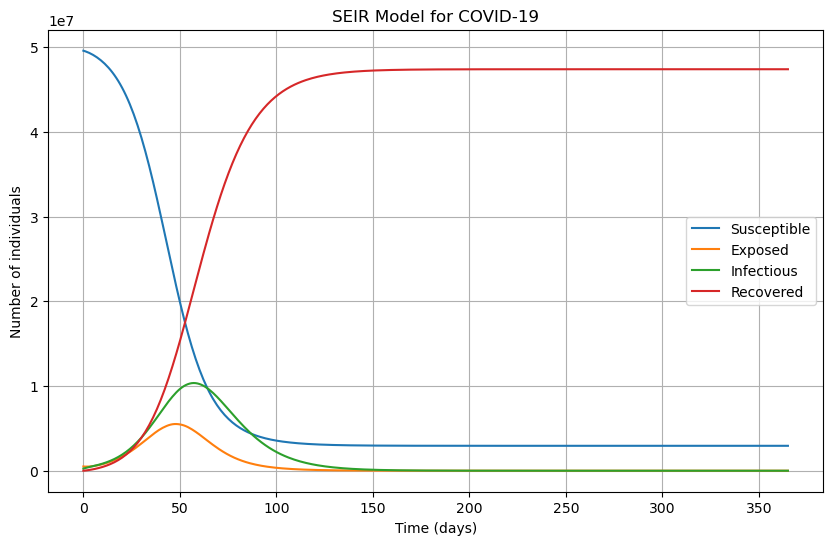

In [51]:
# Total population
N = country_pop['Colombia']

# Initial conditions: S0, E0, I0, R0
E0 = 0.01 * N
I0 = 0.005 * N
R0 = 0  # No recoveries initially
S0 = N - (E0 + I0 + R0)  # Susceptible population

# Parameters
beta = 0.25  # Transmission rate
sigma = 1/5.5  # Incubation rate (1/incubation period)
gamma = 1/12  # Recovery rate (1/infectious period)

# Time span (in days)
t_span = (0, 365)
t_eval = np.linspace(0, 365, 365)

# Solve  problem
# Initial conditions vector
y0 = [S0, E0, I0, R0]

# Solve the SEIR model
sol = solve_ivp(seir_model, t_span, y0, args=(beta, sigma, gamma, N), t_eval=t_eval)

# Extract the solution
S, E, I, R = sol.y

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, S, label='Susceptible')
plt.plot(sol.t, E, label='Exposed')
plt.plot(sol.t, I, label='Infectious')
plt.plot(sol.t, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Number of individuals')
plt.title('SEIR Model for COVID-19')
plt.legend()
plt.grid()
plt.show()

## Loop for all countries

In [52]:
country_pop

{'Brazil': 208126926,
 'Chile': 19331414,
 'Colombia': 50326931,
 'Dominican Republic': 10948573,
 'Germany': 83634807,
 'Italy': 60041302,
 'Mexico': 126356930,
 'Panama': 4267228,
 'US': 339142428,
 'Uruguay': 3397691}

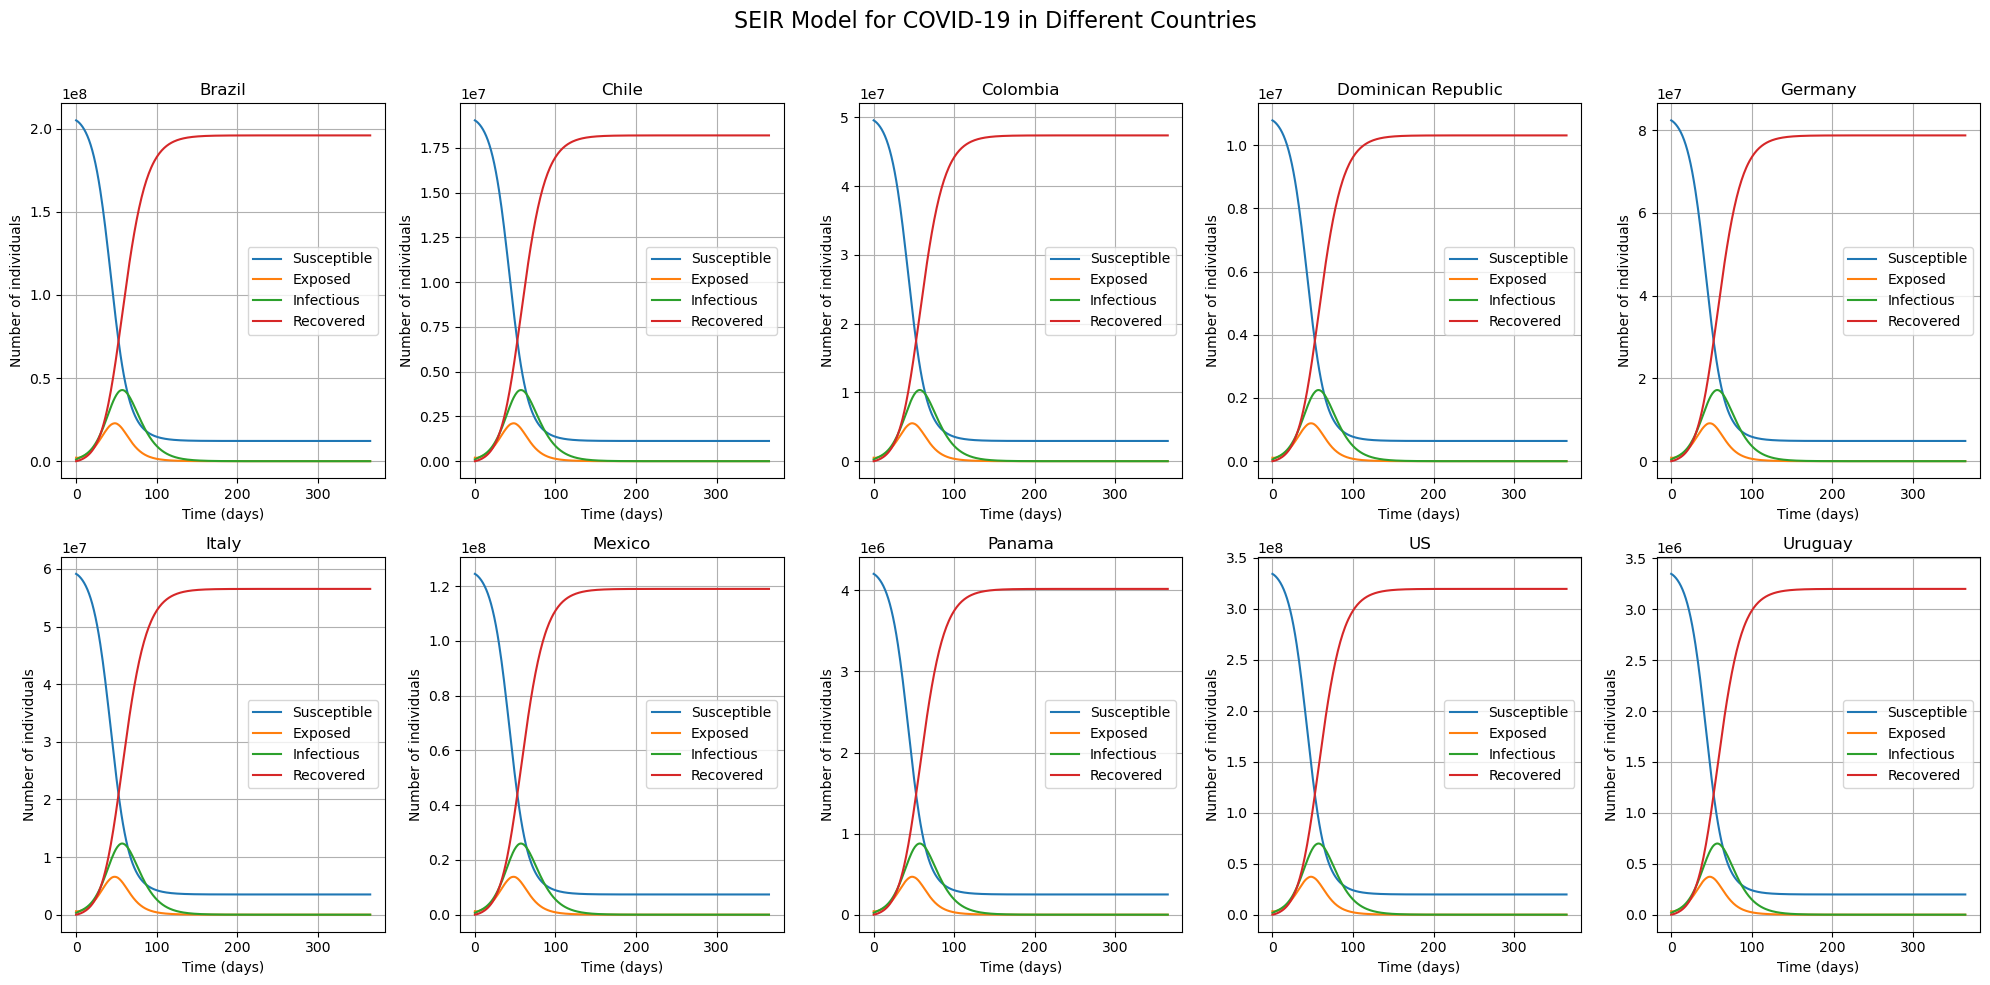

In [53]:
# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('SEIR Model for COVID-19 in Different Countries', fontsize=16)

# Loop through each country and plot in the grid
for i, country in enumerate(countries):
    # Total population
    N = country_pop[country]
    
    # Initial conditions: S0, E0, I0, R0
    E0 = 0.01 * N
    I0 = 0.005 * N
    R0 = 0  # No recoveries initially
    S0 = N - (E0 + I0 + R0)  # Susceptible population
    
    # Parameters
    beta = 0.25  # Transmission rate
    sigma = 1/5.5  # Incubation rate (1/incubation period)
    gamma = 1/12  # Recovery rate (1/infectious period)
    
    # Time span (in days)
    t_span = (0, 365)
    t_eval = np.linspace(0, 365, 365)
    
    # Initial conditions vector
    y0 = [S0, E0, I0, R0]
    
    # Solve the SEIR model
    sol = solve_ivp(seir_model, t_span, y0, args=(beta, sigma, gamma, N), t_eval=t_eval)
    
    # Extract the solution
    S, E, I, R = sol.y
    
    # Plot in the grid
    row = i // 5  # Determine the row (0 or 1)
    col = i % 5   # Determine the column (0 to 4)
    ax = axes[row, col]
    
    ax.plot(sol.t, S, label='Susceptible')
    ax.plot(sol.t, E, label='Exposed')
    ax.plot(sol.t, I, label='Infectious')
    ax.plot(sol.t, R, label='Recovered')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Number of individuals')
    ax.set_title(f'{country}')
    ax.legend()
    ax.grid()

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
plt.show()
    
    

Compare with actual cases and get estimates from: https://www.sciencedirect.com/science/article/pii/S2666720722000145
They set:
* *S(0)* = total population
* *E(0)* = 150 by guesstimation
* *I(0)* = 3 actual data of first contagion
* *R(0)* = 0, actual data /  deaths

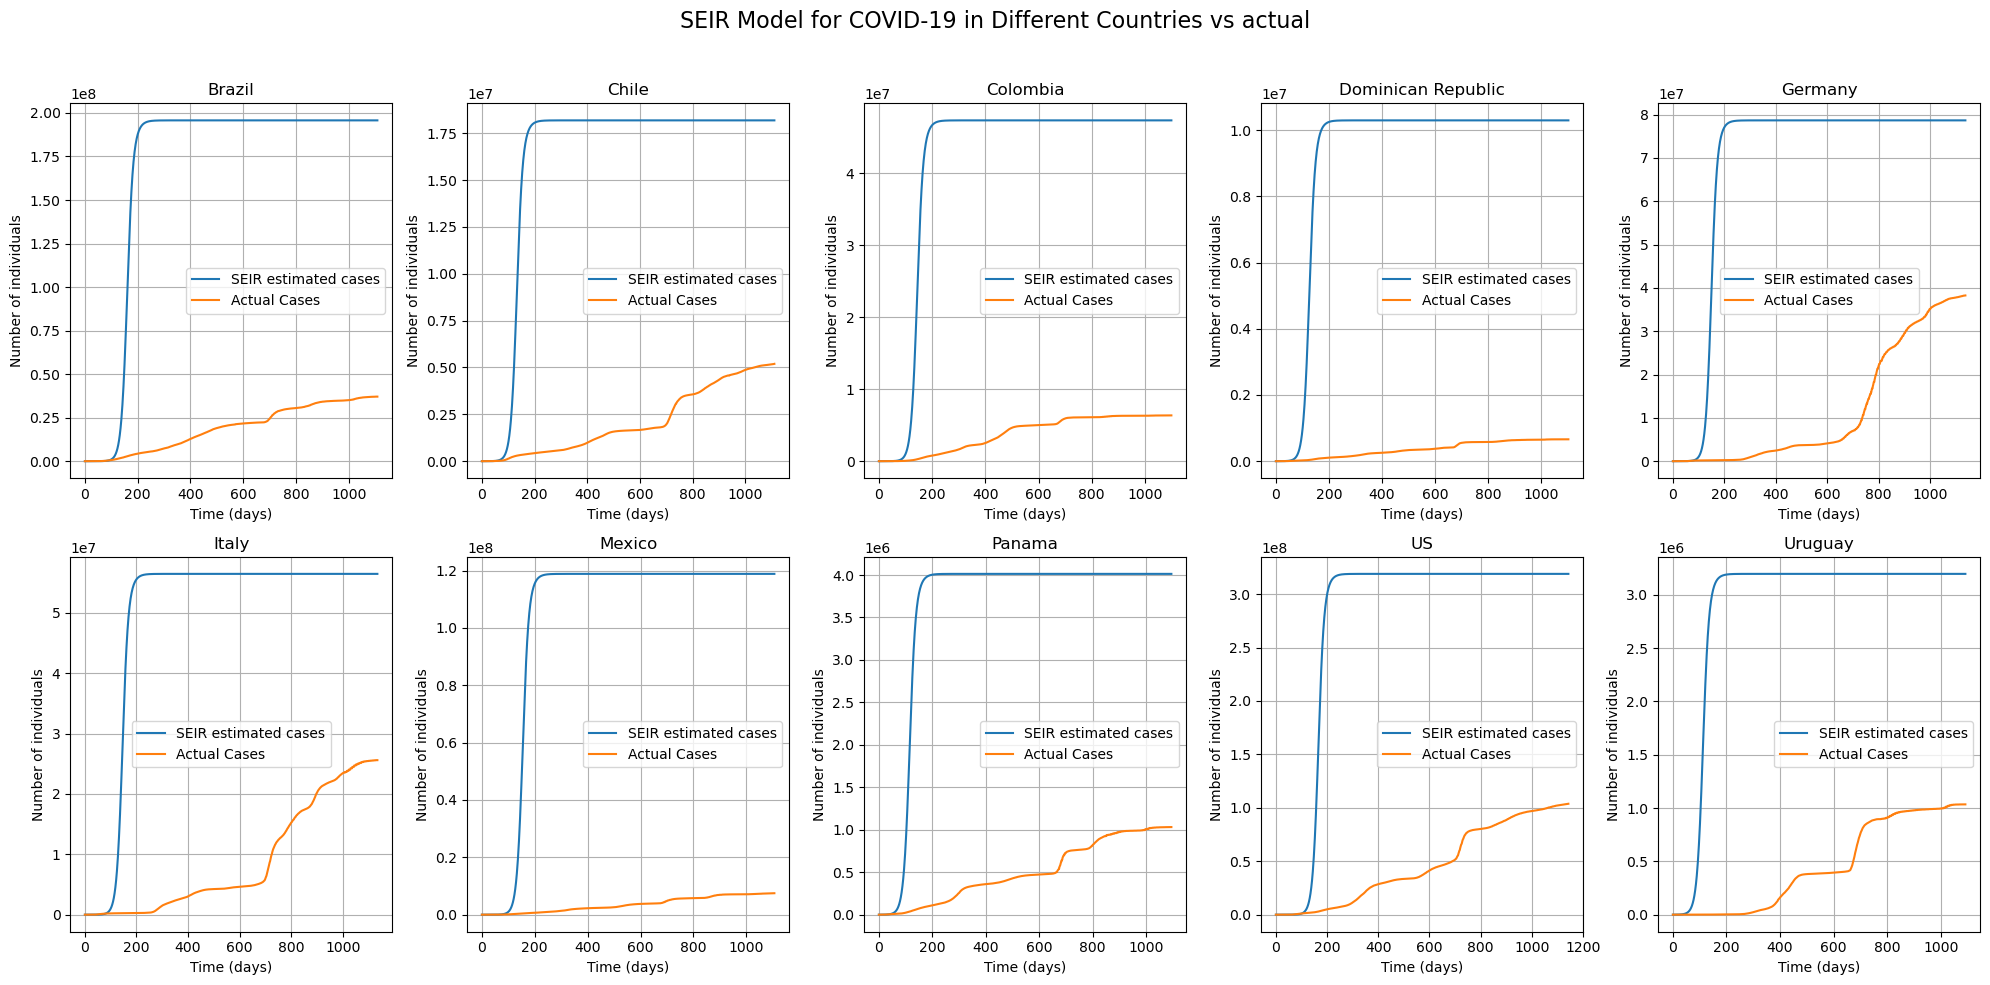

In [54]:
# solve and compare
# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('SEIR Model for COVID-19 in Different Countries vs actual', fontsize=16)

# Loop through each country and plot in the grid
for i, country in enumerate(countries):
    # Total population
    N = country_pop[country]
    df_temp = df_d[df_d['country'] == country].copy().reset_index(drop=True)
    actual_cases = df_temp['cases'] # includes all days 0 0 cases
    actual_cases_ex0 = actual_cases[actual_cases!=0].reset_index(drop=True) # drop first days
    
    # Initial conditions: S0, E0, I0, R0
    I0 = actual_cases_ex0[0]  # Initial active cases (from data)
    R0 = 0   # Initial recovered cases (from data)
    E0 = 150  # Assume exposed cases are twice the infectious cases / Guesstimate
    S0 = N   # Susceptible population

    time = len(actual_cases_ex0)
    
    # Parameters
    beta = 0.25  # Transmission rate
    sigma = 1/5.5  # Incubation rate (1/incubation period)
    gamma = 1/12  # Recovery rate (1/infectious period)
    
    # Time span (in days)
    t_span = (0, time)
    t_eval = np.linspace(0, time, time)
    
    # Initial conditions vector
    y0 = [S0, E0, I0, R0]
    
    # Solve the SEIR model
    sol = solve_ivp(seir_model, t_span, y0, args=(beta, sigma, gamma, N), t_eval=t_eval)
    
    # Extract the solution
    S, E, I, R = sol.y

    C = I + R + E # cummulative number of cases
    
    # Plot in the grid
    row = i // 5  # Determine the row (0 or 1)
    col = i % 5   # Determine the column (0 to 4)
    ax = axes[row, col]
    
    ax.plot(sol.t, C, label='SEIR estimated cases')
    ax.plot(sol.t, actual_cases_ex0, label='Actual Cases')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Number of individuals')
    ax.set_title(f'{country}')
    ax.legend()
    ax.grid()

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
plt.show()

In [55]:
# Loss function for optimization
def loss_function(params, t, actual_cases, N, y0):
    """
    Loss function to minimize.
    params: List of parameters [beta, sigma, gamma]
    t: Time points
    actual_cases: Observed cumulative cases
    N: Total population
    y0: Initial conditions [S0, E0, I0, R0]
    """
    beta, sigma, gamma = params
    
    # Solve the SEIR model
    sol = solve_ivp(seir_model, [t[0], t[-1]], y0, args=(beta, sigma, gamma, N), t_eval=t)
    S, E, I, R = sol.y
    
    # Calculate cumulative cases: C = I + R + E
    C = E + I + R
    
    # Calculate Mean Squared Error (MSE)
    mse = np.mean((C - actual_cases) ** 2)
    return mse

Optimized parameters for Brazil: beta=0.16089913027057673, sigma=0.15520763978667435, gamma=0.1363618354108159
Optimized parameters for Chile: beta=0.14841830137667392, sigma=0.25, gamma=0.12920380524412461
Optimized parameters for Colombia: beta=0.1603704407669736, sigma=0.25, gamma=0.14285714285714285
Optimized parameters for Dominican Republic: beta=0.15452591263388388, sigma=0.15752039726120876, gamma=0.14165646986198627
Optimized parameters for Germany: beta=0.1, sigma=0.14285714285714285, gamma=0.0768068830868331
Optimized parameters for Italy: beta=0.1, sigma=0.15679408069587494, gamma=0.077957767344966
Optimized parameters for Mexico: beta=0.15706230185853398, sigma=0.25, gamma=0.14285714285714285
Optimized parameters for Panama: beta=0.16165432620512662, sigma=0.25, gamma=0.14285714285714285
Optimized parameters for US: beta=0.17069196973458045, sigma=0.25, gamma=0.14285714285714285
Optimized parameters for Uruguay: beta=0.1, sigma=0.24437363782948354, gamma=0.0841424156250841

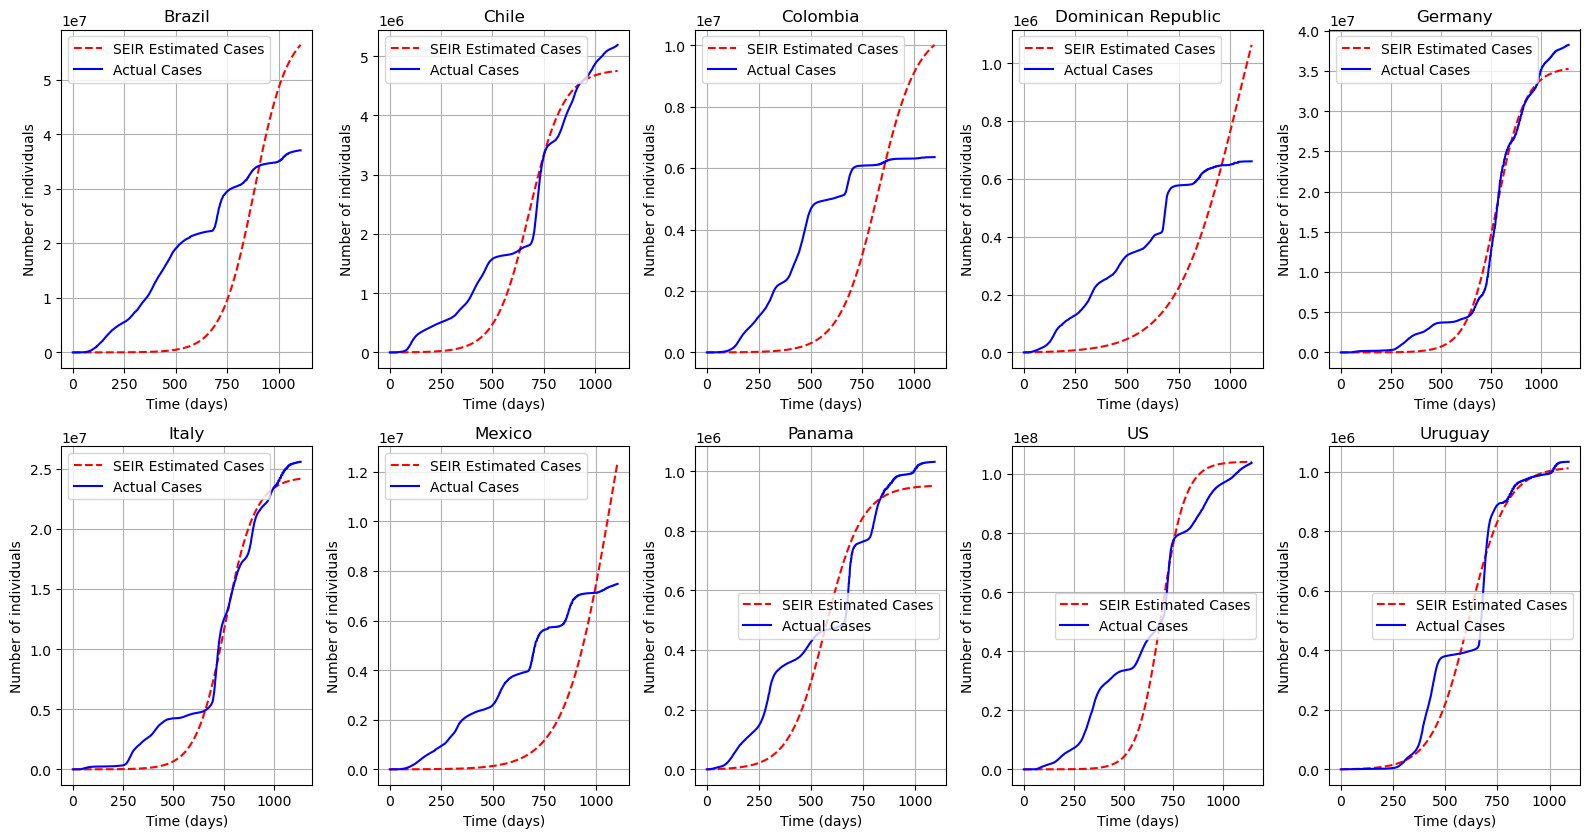

In [57]:
# Dictionary to store metrics for each country
metrics_dict = {}

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 9))  # Adjust the size as needed
# Loop through each country and plot in the grid
for i, country in enumerate(countries):
    # Total population
    N = country_pop[country]
    df_temp = df_d[df_d['country'] == country].copy().reset_index(drop=True)
    actual_cases = df_temp['cases']  # Includes all days, including 0 cases
    actual_cases_ex0 = actual_cases[actual_cases != 0].reset_index(drop=True)  # Drop first days with 0 cases
    
    # Initial conditions: S0, E0, I0, R0
    I0 = actual_cases_ex0[0]  # Initial active cases (from data)
    R0 = 0  # Initial recovered cases (from data)
    E0 = 150  # Assume exposed cases (guesstimate)
    S0 = N - (E0 + I0 + R0)  # Susceptible population
    
    # Time points
    time = len(actual_cases_ex0)
    t = np.arange(time)
    
    # Initial conditions vector
    y0 = [S0, E0, I0, R0]
    
    # Initial parameter guesses
    initial_params = [0.25, 1/5.5, 1/12]  # beta, sigma, gamma
    
    # Bounds for parameters (to ensure they stay within realistic ranges)
    bounds = [(0.1, 0.5), (1/7, 1/4), (1/14, 1/7)]
    
    # Optimize parameters
    result = minimize(loss_function, initial_params, args=(t, actual_cases_ex0, N, y0),
                      method='L-BFGS-B', bounds=bounds)
    
    # Extract optimized parameters
    beta_opt, sigma_opt, gamma_opt = result.x
    print(f"Optimized parameters for {country}: beta={beta_opt}, sigma={sigma_opt}, gamma={gamma_opt}")
    
    # Solve the SEIR model with optimized parameters
    sol = solve_ivp(seir_model, [t[0], t[-1]], y0, args=(beta_opt, sigma_opt, gamma_opt, N), t_eval=t)
    S, E, I, R = sol.y
    
    # Calculate cumulative cases: C = I + R + E
    C = E + I + R
    
    # Calculate RMSE and R²
    rmse = np.sqrt(mean_squared_error(actual_cases_ex0, C)) 
    r2 = r2_score(actual_cases_ex0, C)
    
    
    # Store metrics in the dictionary
    metrics_dict[country] = {'RMSE': rmse, 'R2': r2}
    
    # Plot in the grid
    row = i // 5  # Determine the row (0 or 1)
    col = i % 5   # Determine the column (0 to 4)
    ax = axes[row, col]
    
    ax.plot(sol.t, C, label='SEIR Estimated Cases', color='red', linestyle='--')
    ax.plot(sol.t, actual_cases_ex0, label='Actual Cases', color='blue')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Number of individuals')
    ax.set_title(f'{country}')
    ax.legend()
    ax.grid()

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
plt.savefig('../plots/seir_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [90]:
# Convert dictionary to DataFrame
metrics_df_seir = pd.DataFrame.from_dict(metrics_dict, orient='index')

# Reset index to make 'country' a column
metrics_df_seir.reset_index(inplace=True)
metrics_df_seir.rename(columns={'index': 'Country'}, inplace=True)
metrics_df_seir

,Country,RMSE,R2
0,Brazil,1.326439e+07,-0.098228
1,Chile,5.184690e+05,0.910933
2,Colombia,2.617900e+06,-0.188314
3,Dominican Republic,2.244580e+05,0.039318
4,Germany,1.656545e+06,0.985914
5,Italy,1.697944e+06,0.964894
6,Mexico,2.603995e+06,-0.040384
7,Panama,1.259490e+05,0.871120
8,US,1.485930e+07,0.833893
9,Uruguay,7.368327e+04,0.967430
